# Load a structure, and flow all the way through a neural network

## STEPS Note minor difference to equiformer

1. Configure and load structure with biopandas
2. Tokenize atoms with vocabulary
3. Do full transformation with Atom Featurizer
4. Node and edge embedding
5. a message passing
6. Extract scalar and vector for each node

In [1]:
import os
from e3nn import o3
import torch
import datasets
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt


from e3nn.util.test import assert_equivariant, equivariance_error
EXAMPLE_MFS = os.path.join('..', 'data', 'mf_sites')

## 1. Load a structure

### Multiple structures

In [2]:
from metalsitenn.data import PDBReader

In [3]:
reader = PDBReader(deprotonate=True)
iter = reader.read_dir(EXAMPLE_MFS)

In [4]:
examples = []
for i, ex in enumerate(iter):
    examples.append(ex)
    if i ==3:
        break

In [5]:
ds = datasets.Dataset.from_list(examples)

In [6]:
ds['id']

['5neq_6', '4qql_8', '4yh5_1', '1vvq_144']

## 2. Tokenize atoms with vocabulary

In [7]:
from metalsitenn.atom_vocabulary import AtomTypeVocabulary, AtomVocabulary, AtomTokenizer

type_vocab = AtomTypeVocabulary()
atom_vocab = AtomVocabulary(
    include_hydrogen=False,
    metal_known=False)

In [8]:
atom_tokens = atom_vocab.encode(examples[0]['atoms'])
type_tokens = type_vocab.encode(examples[0]['atom_types'])

In [9]:
atom_tokens

tensor([ 8,  7,  7,  7,  2,  2,  7,  2,  7,  2,  7,  2,  6,  2,  6,  2,  2,  7,
         6,  2,  6,  6,  2,  8,  7,  7,  7,  2,  2,  7,  2,  7,  2,  7,  2,  6,
         2,  7,  6,  2,  7,  2,  2,  8,  7,  7,  7,  2,  2,  7,  2,  7,  2,  7,
         2,  6,  2,  6,  2,  2,  7,  6,  2,  6,  6,  2,  8,  7,  7,  7,  2,  2,
         7,  2,  7,  2,  7,  2,  6,  2,  7,  6,  2,  6,  2,  2,  8,  7,  7,  7,
         2,  2,  7,  2,  7,  2,  7,  2,  6,  2,  7,  6,  2,  6,  2,  2,  8,  7,
         7,  7,  2,  2,  7,  2,  7,  2,  7,  2,  6,  2,  7,  6,  2,  6,  2,  2,
         8,  7,  7,  7,  2,  2,  7,  2,  7,  2,  7,  2,  6,  2,  6,  2,  2,  6,
         6,  2,  6,  2,  7,  8,  7,  7,  7,  2,  2,  7,  2,  7,  2,  7,  2,  6,
         2,  7,  6,  2,  6,  2,  2,  1,  9,  7,  7,  7,  7, 10, 10,  7,  7,  7,
         7])

In [10]:
tokenizer = AtomTokenizer(
    keep_hydrogen=False,
    metal_known=False)

In [11]:
def tokenize(example):
    tokens = tokenizer.tokenize(example['atoms'], example['atom_types'])
    example.update(tokens)
    return example
ds = ds.map(tokenize)

Map:   0%|          | 0/4 [00:00<?, ? examples/s]

In [12]:
ds.set_format('torch')

In [13]:
from metalsitenn.data import AtomicSystemCollator

In [14]:
from torch.utils.data import DataLoader

In [15]:
dl = DataLoader(
    ds,
    batch_size=2,
    collate_fn=AtomicSystemCollator(
        tokenizer=tokenizer,
        mask_rate=None,
        noise_rate=None
    )
)

In [16]:
for batch in dl:
    print(batch)
    break

DataBatch(pos=[317, 3], atoms=[317], atom_types=[317], batch=[317], ptr=[3], atom_tokens=[317, 2])


In [17]:
pos = batch.pos
node_atoms = batch.atoms
node_atom_types = batch.atom_types
node_atom_tokens = batch.atom_tokens
batch_indices = batch.batch

## 4. Node and edge embedding

First create a batch, because we are entering the neural network proper

In [18]:
irreps_high_order = o3.Irreps('128x0e+64x1o+32x2e')

In [19]:
from metalsitenn.nn import AtomEmbedding

In [20]:
# make sure to have more than scalars
irreps_node_embedding = irreps_high_order
atom_embedder = AtomEmbedding(
    categorical_features=[
        (tokenizer.atom_vocab.vocab_size, 16), # embed to 16 hidden dimensions
        (tokenizer.record_vocab.vocab_size, 16) # embed to 16 hidden dimensions for each token
    ],
    continuous_features=None,
    irreps_out=irreps_node_embedding # 128 hidden dimensions after linear sum of concatenated embeddings
)

In [21]:
node_embeddings, node_attrs = atom_embedder(node_atom_tokens)

In [22]:
irreps_node_attrs = o3.Irreps(f"{node_attrs.shape[-1]}x0e")

In [23]:
node_embeddings.shape

torch.Size([317, 480])

Also get one hots

In [24]:
node_attrs.shape

torch.Size([317, 92])

### 4.2 Edge embeddings

eg. radial basis and spherical harmonics

In [25]:
from torch_cluster import radius_graph

In [26]:
DISTANCE_CUTOFF = 5.0
edge_src, edge_dst = radius_graph(
    pos, r=DISTANCE_CUTOFF, batch=batch_indices
)

In [27]:
from equiformer.nets.graph_attention_transformer import (
    GaussianRadialBasisLayer,
    EdgeDegreeEmbeddingNetwork
)

In [28]:
irreps_edge_features = o3.Irreps("16x0e")
num_basis = irreps_edge_features.dim

radial_basis_layer = GaussianRadialBasisLayer(
    num_basis, DISTANCE_CUTOFF
)

In [29]:
edge_vec = pos.index_select(0, edge_src) - pos.index_select(0, edge_dst)
edge_dist = edge_vec.norm(dim=-1)

In [30]:
edge_embedded = radial_basis_layer(edge_dist)

In [31]:
edge_embedded.shape

torch.Size([6229, 16])

In [32]:
LMAX=2
irreps_sh = o3.Irreps.spherical_harmonics(LMAX)
irreps_edge_attr = irreps_sh
edge_sh = o3.spherical_harmonics(
    l=irreps_edge_attr,
    x=edge_vec,
    normalize=True, normalization='component'
)

In [33]:
edge_sh.shape

torch.Size([6229, 9])

### 4.3 Embed edge degree into node embeddings shape

This is essentially an initial equally weighted message passing step of the geometry into the node space

In [34]:
edge_deg_embed = EdgeDegreeEmbeddingNetwork(
    irreps_node_embedding,  # From your AtomEmbedding, does not actually get used, just for shape. This network uses only edge information. This is used so that vectors can be summed.
    irreps_edge_attr,      # From your spherical harmonics  
    fc_neurons=[num_basis, 64, 64],  
    avg_aggregate_num=12  # Typical avg degree in protein structures, adjust as needed
)

In [35]:
edge_degree_embedding = edge_deg_embed(
    node_embeddings,
    edge_sh,
    edge_embedded,
    edge_src,
    edge_dst,
    batch_indices
)

In [36]:
edge_degree_embedding.shape

torch.Size([317, 480])

In [37]:
equivariance_error(
    edge_deg_embed,
    args_in=[
        node_embeddings,
        edge_sh, 
        edge_embedded, 
        edge_src,
        edge_dst, 
        batch_indices],
    irreps_in=[
        irreps_node_embedding,
        irreps_edge_attr,
        irreps_edge_features,
        None, 
        None,
        None
    ],
    irreps_out=irreps_node_embedding
)

{(0, False): tensor([1.2339e-06]), (1, False): tensor([1.4775e-06])}

In [38]:
node_embeddings = node_embeddings + edge_degree_embedding

## 5. Attention layer

### 5.1 layer norm

In [39]:
from equiformer.nets.graph_attention_transformer import get_norm_layer

layer_norm = get_norm_layer("layer")(irreps_node_embedding)

### 5.2 attention

In [40]:
from metalsitenn.nn import GraphAttention

In [41]:
irreps_head = o3.Irreps('32x0e+16x1o+8x2e')

ga = GraphAttention(
    irreps_node_input=irreps_node_embedding,
    irreps_node_attr=irreps_node_attrs,
    irreps_edge_attr=irreps_edge_attr,
    irreps_edge_input=irreps_edge_features,
    irreps_node_output=irreps_node_embedding,
    fc_neurons=[32,32],
    irreps_head=irreps_head,
    num_heads=4,
    proj_drop=0,
    alpha_drop=0
)

In [42]:
node_embeddings_init = node_embeddings.clone()

In [43]:
node_hidden_state = layer_norm(node_embeddings, batch=batch_indices)
node_hidden_state = ga(
    node_hidden_state,
    node_attrs,
    edge_src,
    edge_dst,
    edge_sh,
    edge_embedded,
    batch_indices
)

In [44]:
node_hidden_state.shape

torch.Size([317, 480])

In [45]:
assert_equivariant(
    ga,
    args_in=[
        node_hidden_state,
        node_attrs,
        edge_src,
        edge_dst,
        edge_sh,
        edge_embedded,
        batch_indices],
    irreps_in=[
        irreps_node_embedding,
        irreps_node_attrs,
        None,
        None,
        irreps_edge_attr,
        irreps_edge_features,
        None
    ],
    irreps_out=irreps_node_embedding
)

{(0, False): tensor([3.9028e-07]), (1, False): tensor([4.1723e-07])}

### 5.3 Full transformer block

In [46]:
from metalsitenn.nn import TransformerBlock

In [47]:
tb = TransformerBlock(
    irreps_node_input=irreps_node_embedding,
    irreps_node_attr=irreps_node_attrs,
    irreps_edge_attr=irreps_edge_attr,
    irreps_edge_features=irreps_edge_features,
    irreps_node_output=irreps_node_embedding,
    num_heads=4,
    drop_path_rate=0.0,
    proj_drop=0.0,
    alpha_drop=0.0
)

In [48]:
node_hidden_state = tb(
    node_embeddings,
    node_attrs,
    edge_src,
    edge_dst,
    edge_sh,
    edge_embedded,
    batch_indices
)

In [49]:
node_hidden_state.shape

torch.Size([317, 480])

In [50]:
assert_equivariant(
    tb,
    args_in=[
        node_embeddings,
        node_attrs,
        edge_src,
        edge_dst,
        edge_sh,
        edge_embedded,
        batch_indices],
    irreps_in=[
        irreps_node_embedding,
        irreps_node_attrs,
        None,
        None,
        irreps_edge_attr,
        irreps_edge_features,
        None
    ],
    irreps_out=irreps_node_embedding
)

{(0, False): tensor([1.4630e-06]), (1, False): tensor([1.3155e-06])}

### 5.4 Full model

In [51]:
from metalsitenn.nn import MetalSiteFoundationalModel

In [52]:
trans = MetalSiteFoundationalModel(
    tokenizer=tokenizer,
    max_radius=5.0,
    number_basis=16,
    num_layers=1
)

In [53]:
batch

DataBatch(pos=[317, 3], atoms=[317], atom_types=[317], batch=[317], ptr=[3], atom_tokens=[317, 2])

In [54]:
outs= trans(batch.atom_tokens, batch.pos, batch.batch)

In [55]:
outs

(tensor([[-0.6469, -0.4152, -1.1731,  ..., -0.3393, -0.0064, -0.7536],
         [-1.6847,  1.0438, -0.5586,  ..., -0.1188,  0.4784, -0.0702],
         [-1.6194,  1.1322, -1.2281,  ...,  0.3033,  0.1715, -0.2700],
         ...,
         [-0.4457,  0.4310, -2.7829,  ...,  0.6593, -0.3388,  0.1134],
         [-0.7697,  0.3514, -3.4644,  ...,  0.1105,  0.4017, -0.0488],
         [-1.9311,  0.2853, -6.0955,  ...,  0.1790,  0.1544, -0.2096]],
        grad_fn=<AddBackward0>),
 tensor([[0., 0., 0.,  ..., 0., 1., 0.],
         [0., 0., 0.,  ..., 0., 1., 0.],
         [0., 0., 0.,  ..., 0., 1., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 1.],
         [0., 0., 0.,  ..., 0., 0., 1.],
         [0., 0., 0.,  ..., 0., 0., 1.]]))

## 6. Extract scalar and vector for each node

In [56]:
from metalsitenn.nn import MetalSiteNodeHead, MetalSiteNodeModel

In [57]:
head = MetalSiteNodeHead(
    irreps_node_input=trans.irreps_output,
    irreps_node_attrs=trans.irreps_node_attr,
    tokenizer=tokenizer)

In [58]:
model = MetalSiteNodeModel(
    node_model=trans,
    node_head=head)

Try to rotate inputs

In [59]:
o3.rand_matrix()

tensor([[ 0.5600, -0.3364, -0.7571],
        [ 0.8275,  0.1832,  0.5307],
        [-0.0398, -0.9237,  0.3810]])

In [60]:
unrotated_scalars_atoms, unrotated_scalars_atom_types, unrotated_vectors = model(
    batch.atom_tokens, batch.pos, batch.batch)
starting_scalar_atoms = unrotated_scalars_atoms[0]
starting_scalar_atom_types = unrotated_scalars_atom_types[0]
starting_vector = unrotated_vectors[0].reshape(1,-1)

for i in range(5):
    rot_matrix = o3.rand_matrix()
    rotated_positions = batch.pos @ rot_matrix.T

    rotated_scalars_atoms, rotated_scalars_atom_types, rotated_vectors = model(
        batch.atom_tokens, rotated_positions, batch.batch)
    
    rotated_scalars_atoms = rotated_scalars_atoms[0]
    rotated_scalars_atom_types = rotated_scalars_atom_types[0]
    vector = rotated_vectors[0].reshape(1,-1)

    print(f"Scalar change atoms: {(rotated_scalars_atoms - starting_scalar_atoms)}")
    print(f"Scalar change atom types: {(rotated_scalars_atom_types - starting_scalar_atom_types)}")
    print(f"Starting vector rotated: {(starting_vector @ rot_matrix.T)}")
    print(f"Rotated vector: {vector}")


Scalar change atoms: tensor([ 0.0000e+00,  3.7253e-09, -1.6764e-08, -4.6566e-09, -1.2573e-08,
         1.6764e-08, -3.7253e-09,  1.8626e-08,  3.7253e-09,  4.1910e-09,
        -4.6566e-09, -5.5879e-09,  1.3039e-08,  1.6764e-08,  1.8626e-09,
         2.4214e-08, -3.3528e-08,  9.3132e-09,  1.4901e-08, -2.0489e-08,
        -9.3132e-09,  5.5879e-09, -2.6077e-08, -2.2352e-08,  1.8626e-09,
        -1.3504e-08,  5.5879e-09, -7.4506e-09,  2.9802e-08,  7.4506e-09,
         1.4901e-08,  3.7253e-09,  6.9849e-09, -9.3132e-09, -5.5879e-09,
         5.5879e-09,  2.4214e-08,  2.9802e-08, -5.1223e-09,  3.7253e-09,
        -7.4506e-09,  2.2352e-08,  8.3819e-09, -1.6764e-08, -1.8626e-09,
         1.8626e-09,  2.2352e-08, -9.3132e-10,  2.6077e-08,  0.0000e+00,
         0.0000e+00,  7.4506e-09,  0.0000e+00, -1.9558e-08, -1.8626e-09,
        -4.8894e-09, -1.2806e-09,  1.4901e-08, -1.3039e-08, -9.3132e-09,
        -1.4901e-08,  3.7253e-09, -3.7253e-09, -1.8626e-08,  1.8626e-09,
        -3.7253e-09, -1.1176e-

It is Equivariant on that vector!

## 7. View some 3d plots of output vectors 

In [61]:
dl = DataLoader(
    ds,
    batch_size=1,
    collate_fn=AtomicSystemCollator(
        tokenizer=tokenizer,
        mask_rate=None,
        noise_rate=None
    )
)
for batch in dl:
    print(batch)
    break

DataBatch(pos=[181, 3], atoms=[181], atom_types=[181], batch=[181], ptr=[2], atom_tokens=[181, 2])


In [62]:
atom_scalars, atom_type_scalars, vectors = model(
    batch.atom_tokens, batch.pos, batch.batch)

In [63]:
tokenizer.atom_vocab.itos

{0: '<MASK>',
 1: 'BR',
 2: 'C',
 3: 'CL',
 4: 'F',
 5: 'I',
 6: 'N',
 7: 'O',
 8: 'P',
 9: 'S',
 10: 'METAL'}

In [101]:
# metalsitenn/plotting.py
'''
* Author: Evan Komp
* Created: 11/26/2024
* Company: National Renewable Energy Lab, Bioeneergy Science and Technology
* License: MIT
'''
import torch
from typing import List, Optional, Union
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.patches as mpatches
from matplotlib.lines import Line2D

def plot_atoms_and_vectors(
    positions: torch.Tensor, 
    atom_tokens: Union[List[str], torch.Tensor]=None,
    atom_types: List[int]=None,
    tokenizer: Optional[AtomTokenizer] = None,
    atom_values: Optional[torch.Tensor] = None,
    vectors: Optional[torch.Tensor] = None,
    title: str = "",
    ax = None,
    quiver_multiplier: float=1.0,
    quiver_mask: Optional[torch.Tensor] = None,
    atom_highlight: Optional[torch.Tensor] = None,
    unhighlight_alpha: float=0.4,
    quiver_color: str = 'green'
) -> None:
    """Plot 3D atomic structure with optional vector field for visualizing equivariance.
    
    Color preference hierarchy:
    1. atom_values: Uses viridis colormap with continuous colorbar
    2. atom_tokens: Uses tab20 colormap with discrete colorbar
    3. No color specified: All markers are grey
    
    Marker shapes:
    - atom_types=0: Circle markers
    - atom_types=1: Square markers
    
    Args:
        positions: [N,3] tensor of atomic coordinates
        atom_tokens: List of N atomic tokens or tensor of token indices
        atom_types: List of N atomic types (0 for circle, 1 for square)
        tokenizer: AtomTokenizer object for mapping atom tokens to colors
        atom_values: Optional [N,1] tensor of scalar quantities to color atoms
        vectors: Optional [N,3] tensor of vector quantities to plot as arrows
        title: Title of the plot
        ax: Optional matplotlib axis to plot on
        quiver_multiplier: Multiplier for the length of the vectors
        quiver_mask: Optional mask to plot only a subset of the vectors
        atom_highlight: Optional mask to highlight specific atoms
        unhighlight_alpha: Transparency of unhighlighted atoms
        quiver_color: Color of the vectors
    """
    if ax is None:
        fig = plt.figure(figsize=(8, 8))
        ax = fig.add_subplot(111, projection='3d')

    positions = positions.detach().numpy()
    vectors = vectors.detach().numpy() if vectors is not None else None
    
    # Determine colors and create appropriate colorbar
    if atom_values is not None:
        # Continuous colormap for scalar values
        cmap = plt.cm.viridis
        norm = plt.Normalize(vmin=atom_values.min(), vmax=atom_values.max())
        colors = cmap(norm(atom_values))
        
        # Add colorbar
        sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
        plt.colorbar(sm, ax=ax, label='Atom Values')
        
    elif atom_tokens is not None:
        # Discrete colors for atom tokens
        assert tokenizer is not None, "Must provide tokenizer to map atom symbols to colors"
        
        # Convert tensor indices to tokens if needed
        if isinstance(atom_tokens, torch.Tensor):
            atom_tokens = [tokenizer.atom_vocab.itos[idx.item()] for idx in atom_tokens]
            
        unique_tokens = sorted(set(atom_tokens))
        cmap = plt.cm.tab20
        
        # Create color mapping
        color_dict = {token: cmap(i/len(unique_tokens)) for i, token in enumerate(unique_tokens)}
        colors = [color_dict[token] for token in atom_tokens]
        
    else:
        # Default grey for all markers
        colors = ['grey'] * len(positions)

    # Create legend elements
    legend_elements = []
    
    # Add color legend if using atom_tokens
    if atom_tokens is not None:
        legend_elements.extend([
            Line2D([0], [0], marker='o', color='w', markerfacecolor=color_dict[token],
                  label=token, markersize=10) 
            for token in unique_tokens
        ])
        
    # Add shape legend if using atom_types
    if atom_types is not None:
        shape_elements = [
            Line2D([0], [0], marker='o', color='grey', label='HETATM', 
                  markersize=10, linestyle='None'),
            Line2D([0], [0], marker='s', color='grey', label='ATM', 
                  markersize=10, linestyle='None')
        ]
        # Add shape elements at the beginning of the legend
        legend_elements = shape_elements + legend_elements

    # Plot atoms with appropriate markers and colors
    for i, pos in enumerate(positions):
        if atom_highlight is not None:
            alpha = 1.0 if i in atom_highlight else unhighlight_alpha
        else:
            alpha = 1.0
            
        # Determine marker shape based on atom_types
        marker = 's' if (atom_types is not None and atom_types[i] == 1) else 'o'
        
        ax.scatter(*pos, c=[colors[i]], s=100, alpha=alpha, marker=marker)

    # Add legend if we have any legend elements
    if legend_elements:
        ax.legend(handles=legend_elements, 
                 bbox_to_anchor=(1.15, 1), 
                 loc='upper left')

    # Plot vectors as arrows if provided
    if vectors is not None:
        end_points = vectors * quiver_multiplier
        if quiver_mask is not None:
            positions = positions[quiver_mask]
            end_points = end_points[quiver_mask]

        ax.quiver(
            positions[:,0], positions[:,1], positions[:,2],
            end_points[:,0], end_points[:,1], end_points[:,2],
            color=quiver_color, alpha=1.0
        )

    # Set equal aspect ratio
    ax.set_box_aspect([1,1,1])
    ax.set_title(title)
    
    return ax

<Axes3D: >

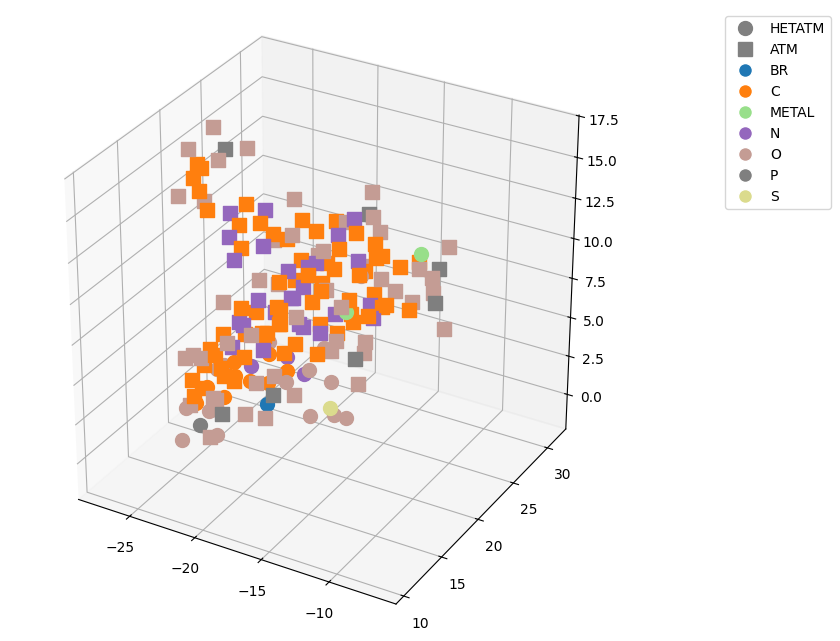

In [94]:
plot_atoms_and_vectors(positions=batch.pos, tokenizer=tokenizer, atom_tokens=batch.atoms, atom_types=batch.atom_types)

In [81]:
atom_scalars.shape

torch.Size([181, 89])

<Axes3D: >

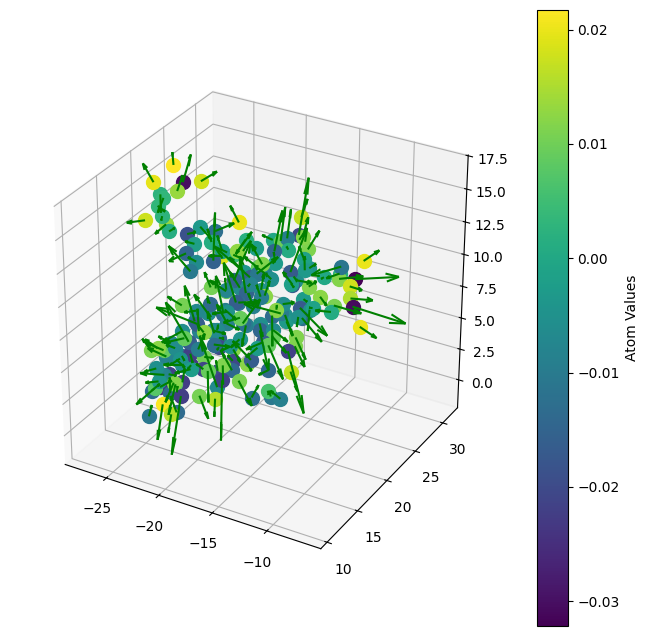

In [96]:
plot_atoms_and_vectors(
    positions=batch.pos,
    tokenizer=tokenizer,
    atom_values=atom_scalars[:,0].detach(),
    vectors=vectors, quiver_multiplier=75)

<Axes3D: >

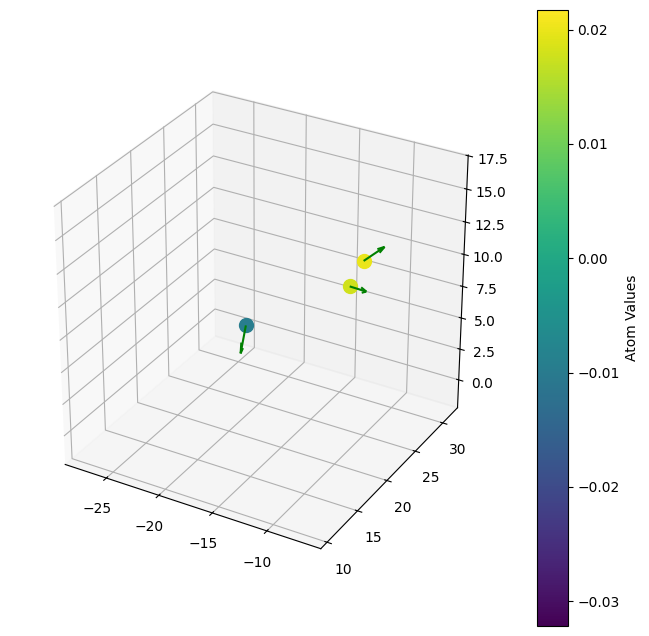

In [129]:
plot_atoms_and_vectors(
    positions=batch.pos,
    tokenizer=tokenizer,
    atom_values=atom_scalars[:,0].detach(),
    vectors=vectors, quiver_multiplier=100, quiver_mask=[1,2,20],
    atom_highlight=[1,2,20], unhighlight_alpha=0.0)



In [132]:
rotation_matrix = o3.rand_matrix()

In [131]:
rotation_matrix

tensor([[-0.0516,  0.9725,  0.2269],
        [-0.9925, -0.0246, -0.1200],
        [-0.1111, -0.2314,  0.9665]])

In [133]:
rotated_pos = batch.pos @ rotation_matrix.T

In [134]:
rotated_vectors = vectors @ rotation_matrix.T

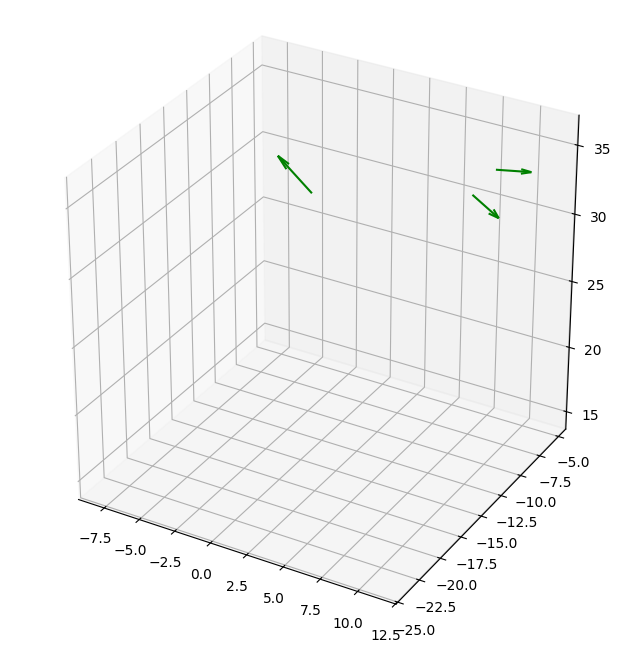

In [136]:
ax = plot_atoms_and_vectors(
    positions=rotated_pos,
    tokenizer=tokenizer,
    vectors=rotated_vectors, quiver_multiplier=100, quiver_mask=[1,2,20],
    atom_highlight=[], unhighlight_alpha=0.0)

In [138]:
_, _, rotated_pos_vectors = model(
    batch.atom_tokens, rotated_pos, batch.batch)


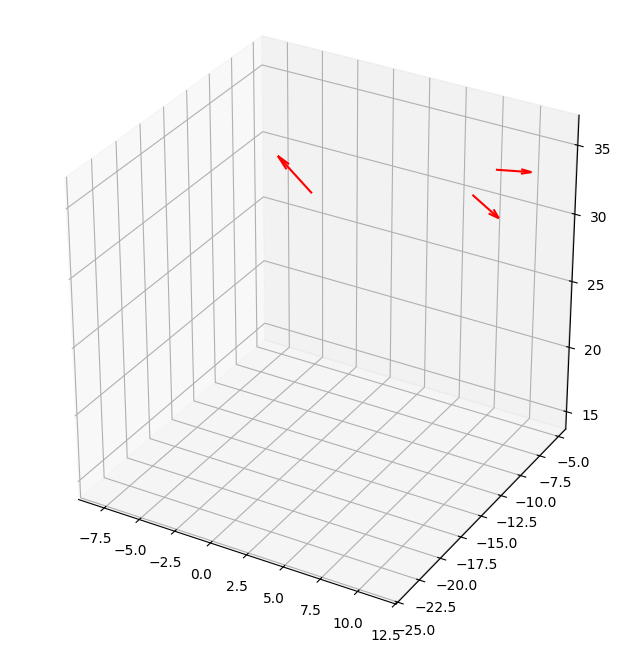

In [140]:
ax = plot_atoms_and_vectors(
    positions=rotated_pos,
    tokenizer=tokenizer,
    vectors=rotated_pos_vectors, quiver_multiplier=100, quiver_mask=[1,2,20],
    atom_highlight=[], unhighlight_alpha=0.0, quiver_color='red')

## 8. parameter size vs various hyperparameters

In [ ]:
num_heads_options = [2,4,8]
hidden_max_order_options = [1,2,3]
hidden_scale_options = [128, 64, 32, 16]
num_layers_options = [1,2,3,5,7,10]

In [ ]:
data = []
for num_heads in num_heads_options:
    for hidden_max_order in hidden_max_order_options:
        for hidden_scale in hidden_scale_options:
            irreps_sh = o3.Irreps.spherical_harmonics(hidden_max_order)
            irreps_internal_base = []
            irreps_head_base= []
            for l in range(hidden_max_order+1):
                irreps_internal_base.append(f"{int(hidden_scale/(l+1))}x{l}e")
                irreps_internal_base.append(f"{int(hidden_scale/(l+1))}x{l}o")
                irreps_head_base.append(f"{int(hidden_scale/num_heads/(l+1))}x{l}e")
                irreps_head_base.append(f"{int(hidden_scale/num_heads/(l+1))}x{l}o")
            irreps_internal= o3.Irreps('+'.join(irreps_internal_base)).simplify()
            irreps_head = o3.Irreps('+'.join(irreps_head_base)).simplify()

            print('Num heads:', num_heads, 'Hidden max order:', hidden_max_order, 'Hidden scale:', hidden_scale)
            print(irreps_internal)
            print(irreps_head)
            print('=================================')
            for num_layers in num_layers_options:
                model = MetalSiteFoundationalModel(
                    irreps_node_embedding=irreps_internal,
                    irreps_sh=irreps_sh,
                    irreps_output=irreps_internal,
                    tokenizer=tokenizer,
                    atom_embedding_dims=16,
                    max_radius=6.0,
                    number_basis=32,
                    fc_neurons=[32, 32],
                    irreps_head=irreps_head,
                    num_head=num_heads,
                    num_layers=num_layers,
                    alpha_drop=0.0,
                    proj_drop=0.0,
                    out_drop=0.0,
                    drop_path_rate=0.0,
                    avg_aggregate_num=12
                )

                num_parameters = sum(p.numel() for p in model.parameters())

                data.append({
                    'num_heads': num_heads,
                    'hidden_max_order': hidden_max_order,
                    'hidden_scale': hidden_scale,
                    'num_layers': num_layers,
                    'num_parameters': num_parameters
                })



Num heads: 2 Hidden max order: 1 Hidden scale: 128
128x0e+128x0o+64x1e+64x1o
64x0e+64x0o+32x1e+32x1o
Num heads: 2 Hidden max order: 1 Hidden scale: 64
64x0e+64x0o+32x1e+32x1o
32x0e+32x0o+16x1e+16x1o
Num heads: 2 Hidden max order: 1 Hidden scale: 32
32x0e+32x0o+16x1e+16x1o
16x0e+16x0o+8x1e+8x1o
Num heads: 2 Hidden max order: 1 Hidden scale: 16
16x0e+16x0o+8x1e+8x1o
8x0e+8x0o+4x1e+4x1o
Num heads: 2 Hidden max order: 2 Hidden scale: 128
128x0e+128x0o+64x1e+64x1o+42x2e+42x2o
64x0e+64x0o+32x1e+32x1o+21x2e+21x2o
Num heads: 2 Hidden max order: 2 Hidden scale: 64
64x0e+64x0o+32x1e+32x1o+21x2e+21x2o
32x0e+32x0o+16x1e+16x1o+10x2e+10x2o
Num heads: 2 Hidden max order: 2 Hidden scale: 32
32x0e+32x0o+16x1e+16x1o+10x2e+10x2o
16x0e+16x0o+8x1e+8x1o+5x2e+5x2o
Num heads: 2 Hidden max order: 2 Hidden scale: 16
16x0e+16x0o+8x1e+8x1o+5x2e+5x2o
8x0e+8x0o+4x1e+4x1o+2x2e+2x2o
Num heads: 2 Hidden max order: 3 Hidden scale: 128
128x0e+128x0o+64x1e+64x1o+42x2e+42x2o+32x3e+32x3o
64x0e+64x0o+32x1e+32x1o+21x2e+21x2o

In [ ]:
model_size_df = pd.DataFrame(data)
model_size_df.to_csv('./data/model_size.csv', index=False)

In [141]:
model_size_df = pd.read_csv('./data/model_size.csv')

In [144]:
model_size_df['num_parameters'].max()/1e6

162.767998

In [ ]:
model_size_df['million_parameters'] = model_size_df['num_parameters'] / 1e6

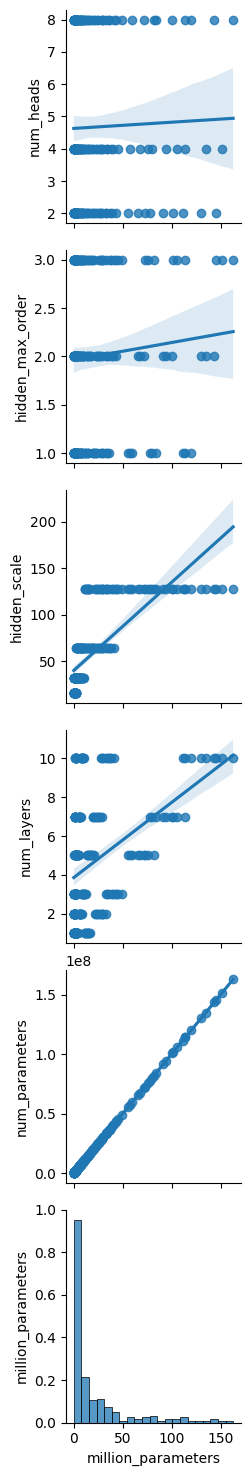

In [ ]:
sns.pairplot(model_size_df, x_vars=['million_parameters'], kind='reg')

In [148]:
get_irreps(l=2, scale=128, decay=0.5, num_heads=4)

(128x0e+128x0o+64x1e+64x1o+32x2e+32x2o, 32x0e+32x0o+16x1e+16x1o+8x2e+8x2o)

## 8. View the model architecture

In [ ]:
from torchview import draw_graph

In [ ]:
graph = draw_graph(
    ga,
    input_data=[node_hidden_state, node_attrs, edge_src, edge_dst, edge_sh, edge_embedded, batch_indices],
    depth=2,
    expand_nested=True,
    hide_module_function=False,
    hide_inner_tensors=True,
    roll=False
)

In [ ]:
graph

In [ ]:
help(draw_graph)

Help on function draw_graph in module torchview.torchview:

draw_graph(model: 'nn.Module', input_data: 'INPUT_DATA_TYPE | None' = None, input_size: 'INPUT_SIZE_TYPE | None' = None, graph_name: 'str' = 'model', depth: 'int | float' = 3, device: 'torch.device | str | None' = None, dtypes: 'list[torch.dtype] | None' = None, mode: 'str | None' = None, strict: 'bool' = True, expand_nested: 'bool' = False, graph_dir: 'str | None' = None, hide_module_functions: 'bool' = True, hide_inner_tensors: 'bool' = True, roll: 'bool' = False, show_shapes: 'bool' = True, save_graph: 'bool' = False, filename: 'str | None' = None, directory: 'str' = '.', **kwargs: 'Any') -> 'ComputationGraph'
    Returns visual representation of the input Pytorch Module with
    ComputationGraph object. ComputationGraph object contains:
    
    1) Root nodes (usually tensor node for input tensors) which connect to all
    the other nodes of computation graph of pytorch module recorded during forward
    propagation.
    


In [ ]:
graph = draw_graph(
    model,
    input_data=[batch.atom_tokens, batch.pos, batch.batch],
    depth=4,
    expand_nested=True,
    hide_module_function=True,
    hide_inner_tensors=True,
    roll=False
)

In [ ]:
dir(graph)

['__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 'add_edge',
 'add_node',
 'check_node',
 'collect_graph',
 'context_tracker',
 'depth',
 'edge_list',
 'expand_nested',
 'fill_visual_graph',
 'get_node_color',
 'get_node_label',
 'get_tail_node',
 'hide_inner_tensors',
 'hide_module_functions',
 'html_config',
 'id_dict',
 'is_node_visible',
 'node_hierarchy',
 'node_set',
 'render_edges',
 'render_nodes',
 'reset_graph_history',
 'resize_graph',
 'roll',
 'rollify',
 'root_container',
 'running_node_id',
 'running_subgraph_id',
 'show_shapes',
 'subgraph_dict',
 'traverse_graph',
 'visual_graph']

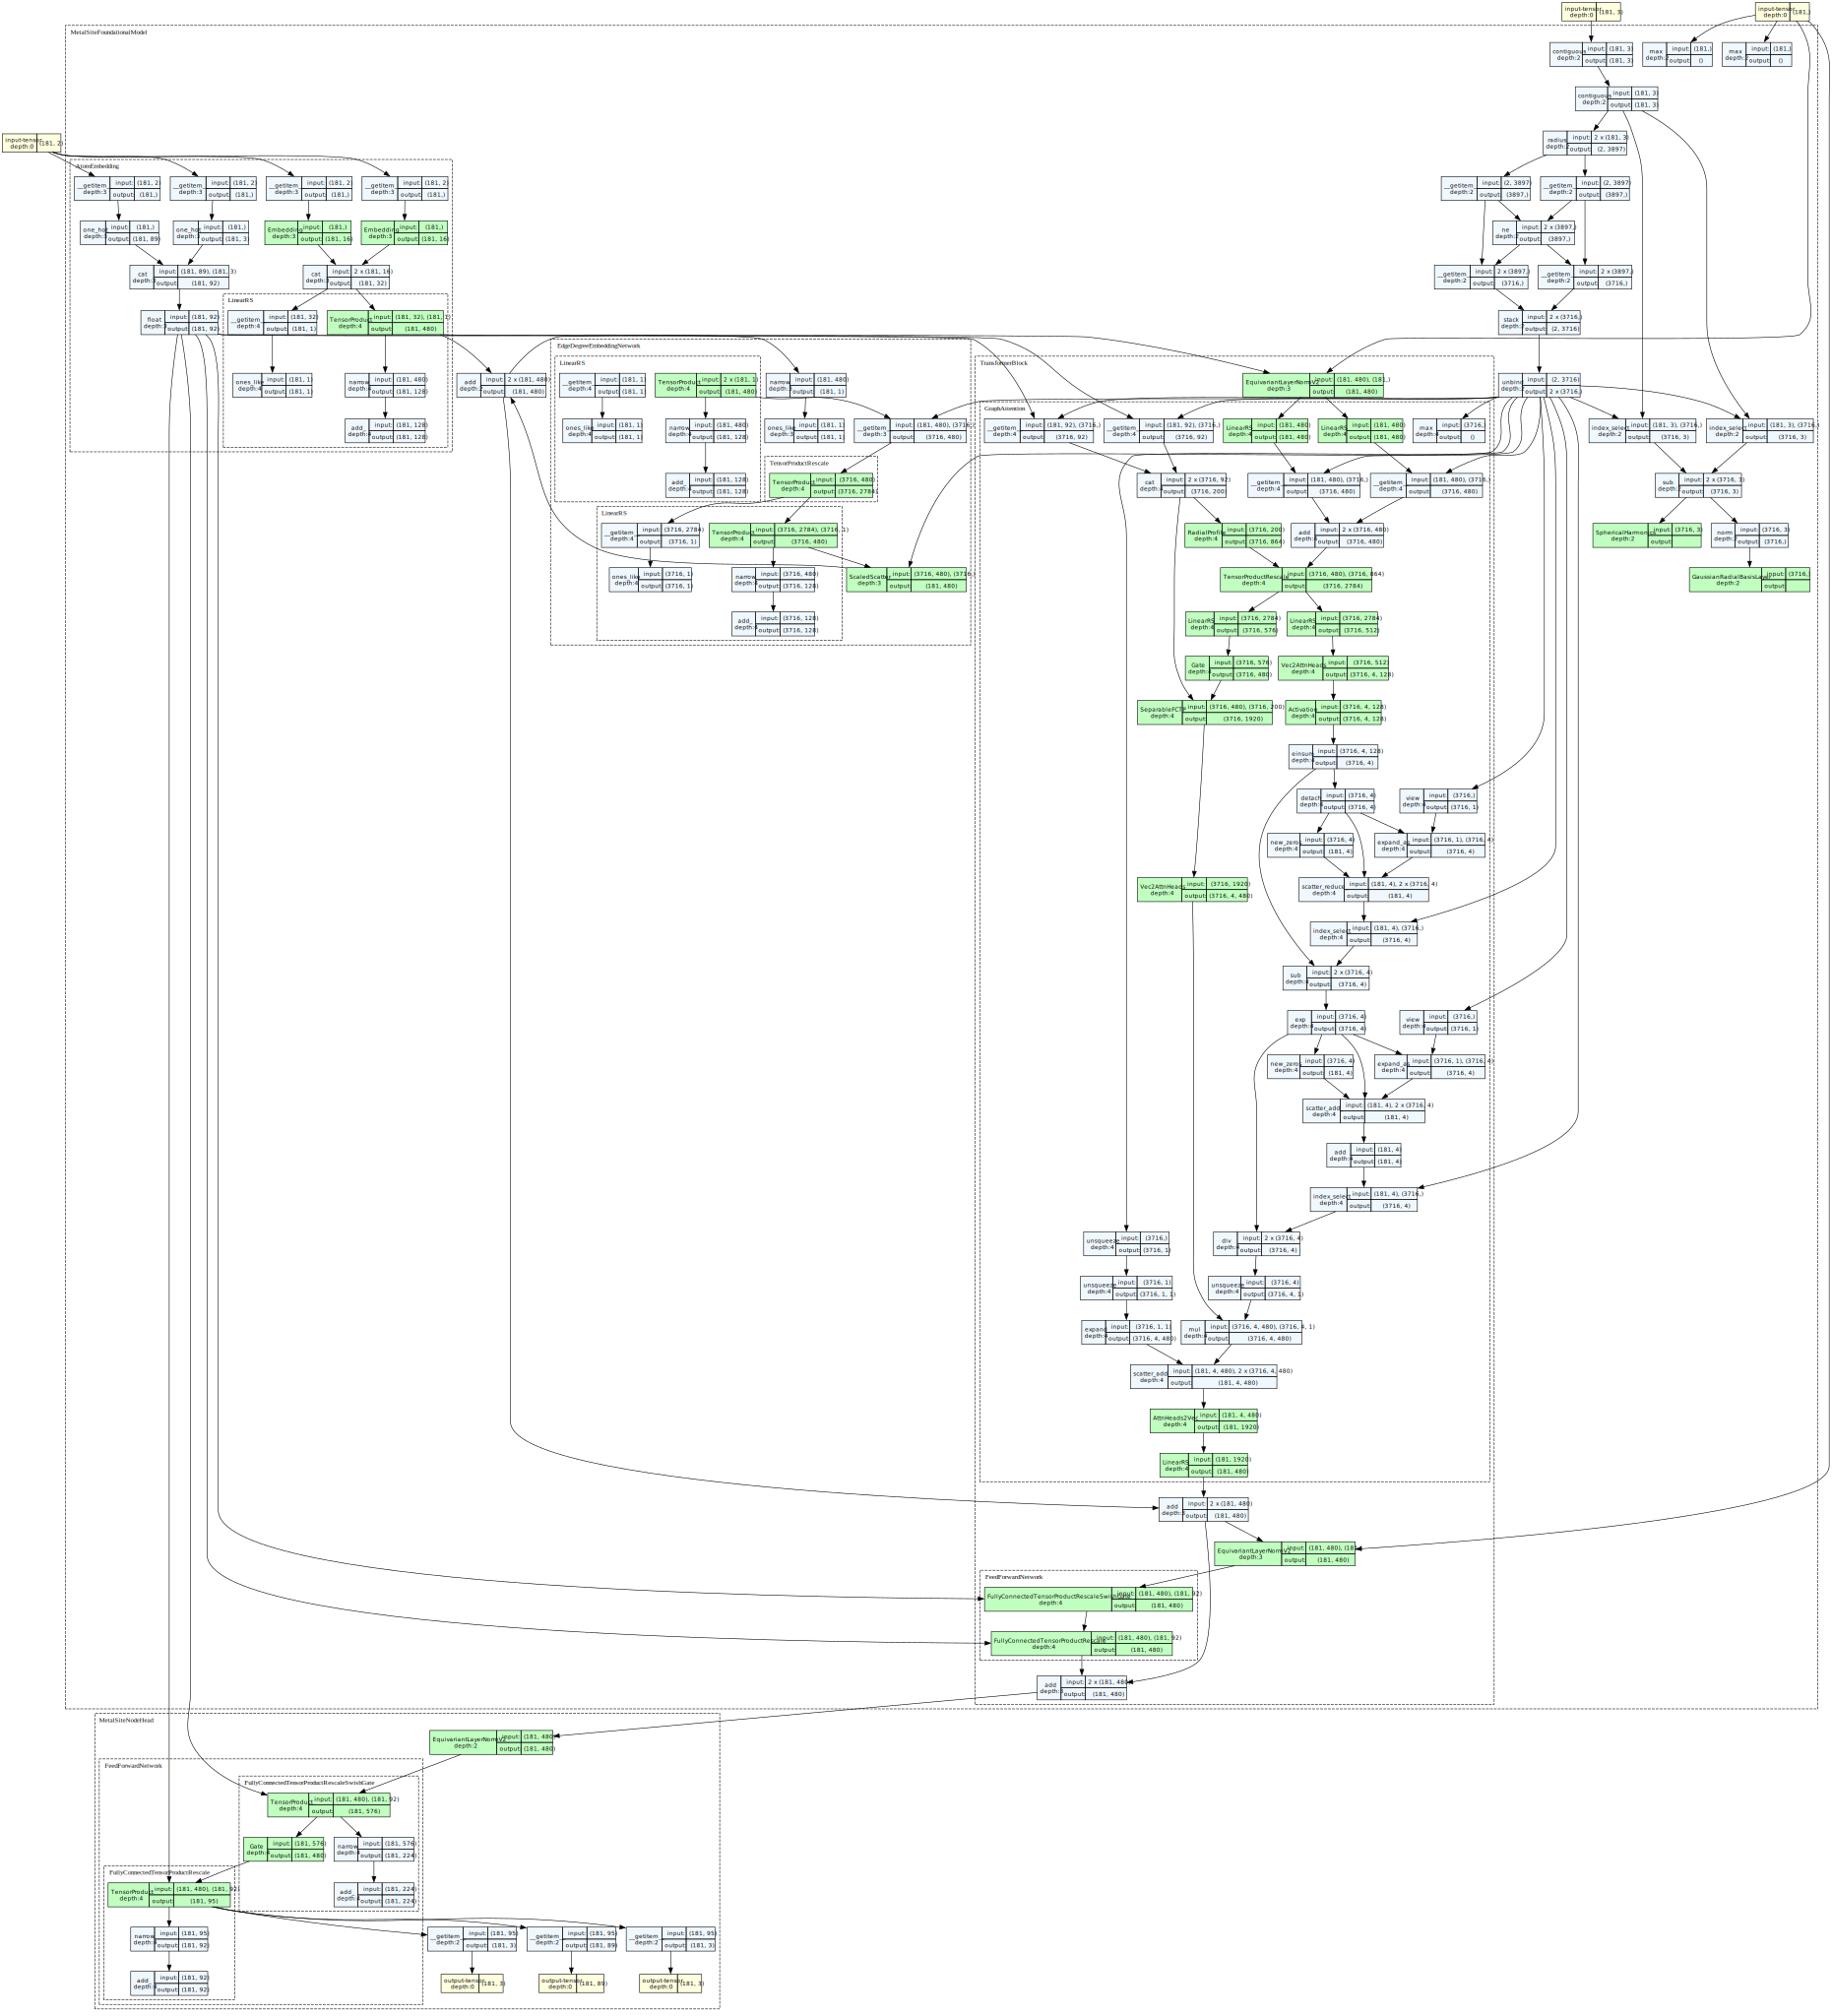

In [ ]:
graph.visual_graph